In [1]:
import os 
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns
from tqdm.notebook import tqdm

# import custom functions
os.chdir('..')
from RuckFunctions import DataLoading, Preprocessing, PACS, PacsFeats


Load data

In [2]:
# Initialize path to data (UTM-converted datasets)
data_dir = os.getcwd() + '\\SampleData'

# Load datasets
raw_datasets = DataLoading.load_data(data_dir)

# Re-shape datasets
datasets = DataLoading.pivot_datsets(raw_datasets)

Get the interpolated data

In [3]:
# get interpolated datasets
interp_datasets = Preprocessing.interpolate_datasets(datasets, threshold = 0.99)

Get movement periods


In [4]:
# get slices for movement periods and break times   
rucks_bySquad, rests_bySquad, all_stops = Preprocessing.get_slices_byArea(interp_datasets, plot=False)

Get the smoothed data of one example squad


In [5]:
smooth_rucks = Preprocessing.spline_smoothing(rucks_bySquad[0], s=3e1, UTM=True)
# smooth_rucks = Preprocessing.spline_smoothing(rucks_bySquad[1], s=3e1, UTM=True)

Get a sample slice of data and apply the Path-Adapted Coordinate System (PACS) transformation

In [6]:
# Orient ruck periods
ruck_slices_oriented = PACS.PACS_transform(smooth_rucks)

re-orienting data


  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [12:42<00:00, 76.24s/it]


Get a names for feature extraction

In [7]:
names = smooth_rucks[0].latitude.columns.tolist()

Spatial Exploration Index (SEI)

In [8]:
SEIs = PacsFeats.get_SEIs(ruck_slices_oriented, names)

100%|██████████| 10/10 [00:00<00:00, 57.26it/s]


Nearest Neighbor (X and Y directions)

In [9]:
x_neighbors, y_neighbors = PacsFeats.get_neighbor_dists(ruck_slices_oriented, names)

Get length/width ratio

In [10]:
LW_ratios = PacsFeats.LW_ratio(ruck_slices_oriented)

Get distribution consistency

In [11]:
X_ftest, Y_ftest = PacsFeats.dist_consistency_Ftest(ruck_slices_oriented, names)
X_wass_df, Y_wass_df = PacsFeats.dist_consistency_wasserstein(ruck_slices_oriented, names)

Plotting

In [12]:
# define colors for all plots 
color_dictionary = dict(zip(names, sns.color_palette(as_cmap=True)[:len(names)]))

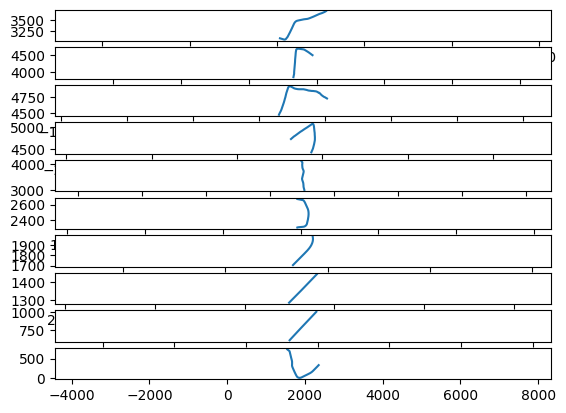

In [13]:
# find best turn 

fig, axs = plt.subplots(len(smooth_rucks))

for smruck, ax in zip(smooth_rucks, axs):
    ax.plot(smruck[[r for r in smruck.columns if 'UTM_x' in r]].mean(axis=1), smruck[[r for r in smruck.columns if 'UTM_y' in r]].mean(axis=1))
    ax.set_aspect('equal', adjustable="datalim")


In [14]:
# random_slice.to_pickle(r'C:\Users\James\Downloads\rndslcs.pkl')
# random_PACS_slice.to_pickle(r'C:\Users\James\Downloads\rndpacsslcs.pkl')

In [15]:
len(smooth_rucks[1])

961

In [16]:
# set length of time period to plot
time_length = 40

# # get random time periods
# random_period = np.random.randint(len(ruck_slices_oriented))
# random_timepoint = np.random.randint(len(ruck_slices_oriented[random_period])-time_length)

random_period = 2
random_timepoint = 200

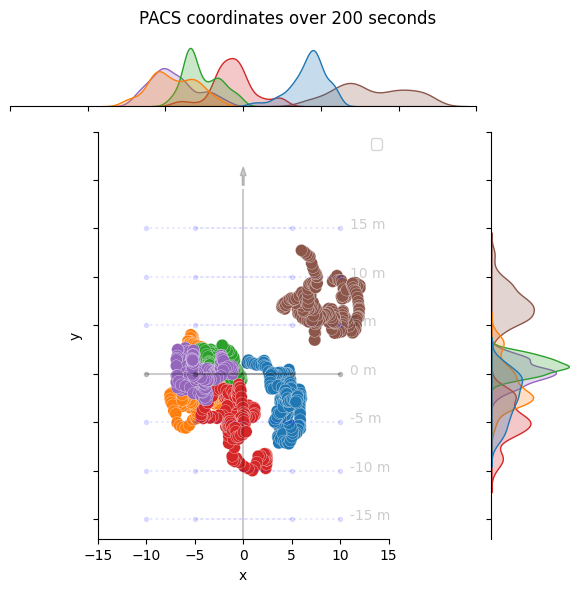

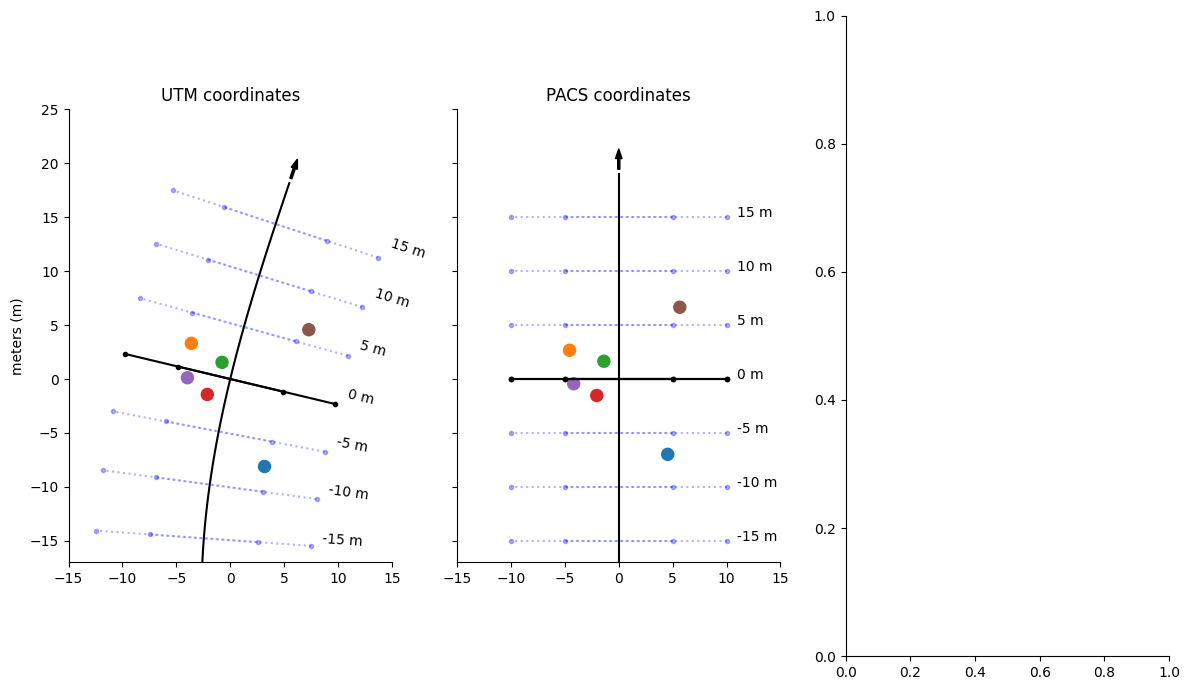

In [19]:
time_length = 200

# # get random time periods
# random_period = np.random.randint(len(ruck_slices_oriented))
# random_timepoint = np.random.randint(len(ruck_slices_oriented[random_period])-time_length)

random_period = 2
random_timepoint = 100

# get section
random_slice = smooth_rucks[random_period].iloc[random_timepoint:random_timepoint+time_length]
random_PACS_slice = ruck_slices_oriented[random_period].iloc[random_timepoint:random_timepoint+time_length]

#  get a sample path
x_UTM = random_slice[[('UTM_x', n)for n in names]].mean(axis=1)
y_UTM = random_slice[[('UTM_y', n) for n in names]].mean(axis=1)

# Get equivalent PACS coordinates
# make straight line to represent forward movement
x_PACS = pd.Series(0 * np.arange(time_length))
y_PACS = pd.Series(np.arange(time_length))

indivs_data = []

for name in names:
    this_person_data = random_PACS_slice[[c for c in random_PACS_slice.columns if name in c]]
    this_person_data.columns = 'x', 'y'
    this_person_data['ID']=name
    indivs_data.append(this_person_data)

data_to_plot = pd.concat(indivs_data)


jointfig = sns.jointplot(data=data_to_plot.reset_index(), x='x', y='y', hue='ID', dropna=True, palette = color_dictionary, linewidth=.2, joint_kws ={'s': 75})
jointfig.ax_joint.set_aspect('equal')

plt.suptitle('PACS coordinates over ' +str(time_length)+ ' seconds')

jointfig.ax_joint.legend([])

jointfig.ax_joint.set_ylim([-15,25])
jointfig.ax_joint.set_xlim([-15,15])

plt.tight_layout()

# set length of time period to plot
time_length = 40

# # get random time periods
# random_period = np.random.randint(len(ruck_slices_oriented))
# random_timepoint = np.random.randint(len(ruck_slices_oriented[random_period])-time_length)

random_period = 2
random_timepoint = 200

# # set length of time period to plot
# time_length = 40

# # # get random time periods
# # random_period = np.random.randint(len(ruck_slices_oriented))
# # random_timepoint = np.random.randint(len(ruck_slices_oriented[random_period])-time_length)

# random_period = 2
# random_timepoint = 510

# get section
random_slice = smooth_rucks[random_period].iloc[random_timepoint:random_timepoint+time_length]
random_PACS_slice = ruck_slices_oriented[random_period].iloc[random_timepoint:random_timepoint+time_length]

#  get a sample path
x_UTM = random_slice[[('UTM_x', n)for n in names]].mean(axis=1)
y_UTM = random_slice[[('UTM_y', n) for n in names]].mean(axis=1)


# Get equivalent PACS coordinates
# make straight line to represent forward movement
x_PACS = pd.Series(0 * np.arange(time_length))
y_PACS = pd.Series(np.arange(time_length))

from scipy import interpolate
from scipy.integrate import quad
from scipy.interpolate import UnivariateSpline
from tqdm.notebook import tqdm
import random
from scipy.optimize import minimize

# additional helper functions

s, u = interpolate.splprep([x_UTM, y_UTM])

def foo(u):
    xx,yy=interpolate.splev(u,s,der=1)
    return (xx**2 + yy**2)**0.5

# Integration function
def integrand(x):
    '''Finding distance along spline of two points'''
    dx_dt = splines[0].derivative()(x)
    dy_dt = splines[1].derivative()(x)
    return np.sqrt(dx_dt**2 + dy_dt**2)


# choose units (UTM or coords)
pts = pd.concat([x_UTM, y_UTM], axis=1).to_numpy()

# get distance values
distance = np.cumsum( np.sqrt(np.sum( np.diff(pts, axis=0)**2, axis=1 )) )
distance = np.insert(distance, 0, 0)#/distance[-1]

# make a spline for each axis
splines = [UnivariateSpline(distance, coords, k=3, s=50) for coords in pts.T]


points_fitted = np.vstack( spl(distance) for spl in splines ).T

spaced_distance = np.arange(len(distance))

points_spaces = np.vstack( spl(spaced_distance) for spl in splines ).T

x_UTM = pd.Series(points_spaces[:,0])
y_UTM = pd.Series(points_spaces[:,1])


# tick params

# set which tick to make as t=0
# make a ratio of total time period
ztick = time_length//2


# tick parameters
dist_from_line = 10
n_ticks = 2

# make paths with respect to zero (t=0)
x_UTM = x_UTM - x_UTM.iloc[int(ztick)]
y_UTM = y_UTM - y_UTM.iloc[int(ztick)]

x_PACS = x_PACS - x_PACS.iloc[int(ztick)]
y_PACS = y_PACS - y_PACS.iloc[int(ztick)]


# make plots
fig, axs = plt.subplots(1, 3)

axs[2] = jointfig.ax_joint

# loop through two plots. UTM and PACS
for x, y, ax, plottype in zip([x_UTM, x_PACS, x_PACS], [y_UTM, y_PACS, y_PACS], axs, ['UTM', 'PACS', 'joint']):

    # set up curve
    curve_df = pd.DataFrame()
    curve_df['x'] = x
    curve_df['y'] = y

    # get normalized slope for y axis ticks
    curve_diff = curve_df.diff()
    curve_slope = curve_diff['y'] / curve_diff['x']
    norm_slope = -1/curve_slope

    # plot the path

    if plottype == 'joint':
        ax.plot(x, y, color='k', label='Path', alpha=0.2)
        ar = ax.arrow(x.iloc[-1], y.iloc[-1],dx=x.diff().iloc[-1], dy=y.diff().iloc[-1], color='k', width=0.2, head_starts_at_zero = 1, alpha=0.2)
    else:
        ax.plot(x, y, color='k', label='Path')
        ar = ax.arrow(x.iloc[-1], y.iloc[-1],dx=x.diff().iloc[-1], dy=y.diff().iloc[-1], color='k', width=0.2, head_starts_at_zero = 1)

    # initialize x and y vals for ticks
    X_vals = []
    Y_vals = []

    # plot every X ticks
    evtick = 5

    # plot ticks
    for count, (this_x, this_y, this_slope) in enumerate(zip(x[::evtick], y[::evtick], norm_slope[::evtick])):
        
        # if slop is na skip
        if math.isnan(this_slope): continue

        # assign m as slope
        m = this_slope

        # loop through steps in path to plot ricks
        for l in np.arange(0, dist_from_line/n_ticks + dist_from_line, dist_from_line/n_ticks)[1:]:

            # ticks here
            dx = (l / math.sqrt(1 + (m * m)))
            dy = m * dx
            Px = this_x + dx
            Py = this_y + dy
            Nx = this_x - dx
            Ny = this_y - dy

            # append ticks
            X_vals = [Px, Nx]
            Y_vals = [Py, Ny]

            # make t=0 a darker tick
            if count == (ztick//evtick):
                if plottype == 'PACS':
                    ax.plot(X_vals, Y_vals, color='k', marker = '.', markevery=1, label = 't = 0')
                if plottype == 'joint':
                    ax.plot(X_vals, Y_vals, color='k', marker = '.', markevery=1, alpha = 0.2)
                else:
                    ax.plot(X_vals, Y_vals, color='k', marker = '.', markevery=1)
            else:
                if plottype == 'joint':
                    ax.plot(X_vals, Y_vals, ls=':', color='b', marker = '.', markevery=1, alpha = 0.1)
                else:
                    ax.plot(X_vals, Y_vals, ls=':', color='b', marker = '.', markevery=1, alpha = 0.3)
            
            if not l == dist_from_line/n_ticks:
                if plottype == 'joint': alpha=0.2
                else: alpha=1
                ax.text(X_vals[0] + 1 , Y_vals[0], f'{(count-4)*evtick} m', rotation = math.degrees(math.tanh(m)), alpha=alpha)


            ax.set_ylim([-17,25])
            ax.set_xlim([-15,15])
            ax.set_aspect('equal')#, adjustable="datalim")
            if plottype =='UTM': ax.set_ylabel('meters (m)')#; ax.set_yticklabels([])
            else: ax.set_yticklabels([])
            # ax.set_xticklabels([str(x)+' m' for x in ax.get_xticklabels()])


dot_size = 75

# plot individuals on path at that time 0
axs[0].scatter(random_slice.iloc[int(ztick)][[('UTM_x', n)for n in names]] - random_slice.iloc[int(ztick)][[('UTM_x', n)for n in names]].mean(), random_slice.iloc[int(ztick)][[('UTM_y', n)for n in names]] - random_slice.iloc[int(ztick)][[('UTM_y', n)for n in names]].mean(), c = [color_dictionary[n] for n in names], s=dot_size)

axs[1].scatter(random_PACS_slice.iloc[int(ztick)][[n+' longitude' for n in names]], random_PACS_slice.iloc[int(ztick)][[n+' latitude' for n in names]], c = [color_dictionary[n] for n in names], s=dot_size)

axs[0].set_title('UTM coordinates')
axs[1].set_title('PACS coordinates')


fig.set_size_inches(12, 7)

# axs[0].legend()
# axs[1].legend()

plt.tight_layout()

sns.despine()
plt.show()

In [321]:
len(ax.get_xticklabels())

7

In [232]:
# set length of time period to plot
# time_length = 200

# # # get random time periods
# # random_period = np.random.randint(len(ruck_slices_oriented))
# # random_timepoint = np.random.randint(len(ruck_slices_oriented[random_period])-time_length)

# random_period = 2
# # random_timepoint = 1650
# random_timepoint = 1750

# set length of time period to plot
time_length = 200

# # get random time periods
# random_period = np.random.randint(len(ruck_slices_oriented))
# random_timepoint = np.random.randint(len(ruck_slices_oriented[random_period])-time_length)

random_period = 2
random_timepoint = 100

# get section
random_slice = smooth_rucks[random_period].iloc[random_timepoint:random_timepoint+time_length]
random_PACS_slice = ruck_slices_oriented[random_period].iloc[random_timepoint:random_timepoint+time_length]

#  get a sample path
x_UTM = random_slice[[('UTM_x', n)for n in names]].mean(axis=1)
y_UTM = random_slice[[('UTM_y', n) for n in names]].mean(axis=1)

# Get equivalent PACS coordinates
# make straight line to represent forward movement
x_PACS = pd.Series(0 * np.arange(time_length))
y_PACS = pd.Series(np.arange(time_length))

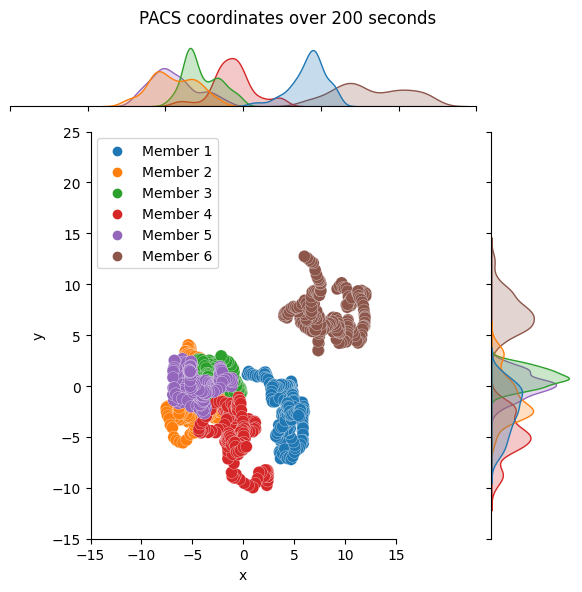

In [237]:
indivs_data = []

for name in names:
    this_person_data = random_PACS_slice[[c for c in random_PACS_slice.columns if name in c]]
    this_person_data.columns = 'x', 'y'
    this_person_data['ID']=name
    indivs_data.append(this_person_data)

data_to_plot = pd.concat(indivs_data)


jointfig = sns.jointplot(data=data_to_plot.reset_index(), x='x', y='y', hue='ID', dropna=True, palette = color_dictionary, linewidth=.2, joint_kws ={'s': 75})
jointfig.ax_joint.set_aspect('equal')

plt.suptitle('PACS coordinates over ' +str(time_length)+ ' seconds')

jointfig.ax_joint.legend(fontsize=10, loc='upper left')

jointfig.ax_joint.set_ylim([-15,25])
jointfig.ax_joint.set_xlim([-15,15])

plt.tight_layout()





In [138]:
from scipy import interpolate
from scipy.integrate import quad
from scipy.interpolate import UnivariateSpline
from tqdm.notebook import tqdm
import random
from scipy.optimize import minimize

# additional helper functions

# Distance to spline function
def dp2s(t,sx,sy,x0,y0):
    """
    Define the distance from point to spline

    Args:
        t (float): timepoint (normalized to 1 for spline)
        sx (scipy.UnivariateSpline object): spline of x
        sy (scipy.UnivariateSpline object): spline of y
        x0 (float): x coordinate
        y0 (float): y coordinate

    Returns:
        d (float): distance from point
        g (float): gradient at point on spline
    """

    # Spline to point distances
    tmpx = sx(t)-x0
    tmpy = sy(t)-y0
    
    # The Euclidean distance
    d = math.sqrt(tmpx**2 + tmpy**2)
    
    # The gradient
    g = 2*tmpx*sx.derivative(n=1)(t) + 2*tmpy*sy.derivative(n=1)(t)

    return d, g

# Force convergence function
def force_converge(t0, args4d):
    """
    Force the minimization function used to converge on the nearest spline point
    iterate 100x before incrreasing (doubling) the tolerance

    Args:
        t0 (int): initial guess
        args4d (list): packaged parameters for the distance calculation [x spline, y spline, x coord, y coord]

    Returns:
        rac (scipy.optimize._optimize.OptimizeResult object) : result of converged minimization problem
    """

    # Compute the minimzation which will result in new new cordinate:
    rac = minimize(dp2s, t0, args=args4d, jac = True, 
                method='BFGS', tol = 1e-6, options={'disp' : False})
    
    i = 0
    
    # initialize tolerance
    tol = 1e-6
    
    # loop until convergence
    while not rac.success:
        
        # make new guess (with random)
        t0_rand = t0 + (random.random()*10)
        
        # compute minimization again
        rac = minimize(dp2s, t0_rand, args=args4d, jac = True, 
                    method='BFGS', tol = tol, options={'disp' : False})
        
        # add one to iteration count
        i += 1
        
        # increase colorance if not converging in 100 iterations
        if i>100:
            
            # double tolerance level
            tol = tol*2
            
            # reset iteration count
            i=0
            pass
    
    # return converged
    return rac

# Integration function
def integrand(x):
    '''Finding distance along spline of two points'''
    dx_dt = splines[0].derivative()(x)
    dy_dt = splines[1].derivative()(x)
    return np.sqrt(dx_dt**2 + dy_dt**2)


pts = pd.concat([x_UTM, y_UTM], axis=1).to_numpy()
    
# get distance values
distance = np.cumsum( np.sqrt(np.sum( np.diff(pts, axis=0)**2, axis=1 )) )
distance = np.insert(distance, 0, 0)#/distance[-1]

# different smoothing factors depending on coordinate system
# make a spline for each axis
splines = [UnivariateSpline(distance, coords, k=3, s=1) for coords in pts.T]

# s = interpolate.splrep(x_UTM, y_UTM, s=1)

spl_idx = 0.2

ys = []
xs = []

spl_pt = [x_UTM.iloc[0], x_UTM.iloc[1]]


for x_s in tqdm(x_UTM):

    
    args4d = (splines[0], splines[1], spl_pt[0], spl_pt[1])

    rac = force_converge(spl_idx, args4d)

    spl_pt = (rac.x[0], rac.fun)

    spl_idx = spl_idx - 0.01

    ys.append(spl_pt[0])
    xs.append(spl_pt[1])

    spl_len = 0

    # find next x coord that is 1 m away along spline
    while spl_len > 1.1 or spl_len < 0.9:

        spl_test = spl_idx + 1

        rac = force_converge(spl_idx, args4d)

        next_spl_pt = (rac.x[0], rac.fun)

        spl_len, _ = quad(integrand, spl_pt[0], next_spl_pt[0], limit=1000, epsabs=1e-5, epsrel=1e-5)

        print(spl_len)

        assert spl_len > 0, 'negative spl len'
        
    spl_pt = next_spl_pt

y_UTM = pd.Series(ys)
x_UTM = pd.Series(xs)


  0%|          | 0/200 [00:00<?, ?it/s]

0.009166945837820104


KeyboardInterrupt: 